# 프로젝트 : 주식 예측 도전

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## STEP 1. 시계열 데이터 준비

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행
* 결측치 처리
* 로그 변환

In [4]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

* 결측치가 없습니다.

In [5]:
ts

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
               ...   
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, Length: 250, dtype: float64

In [6]:
ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

## STEP 3. 시계열 안정성 분석

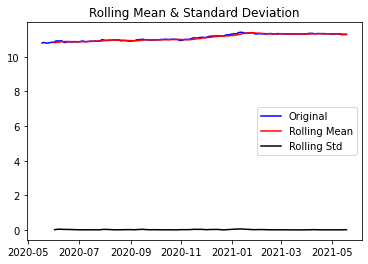

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


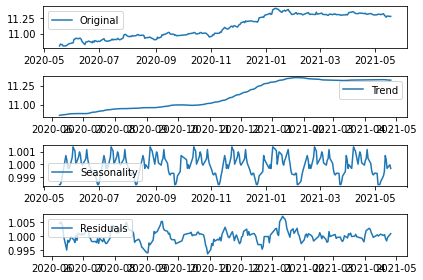

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4. 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋을 분리합니다.

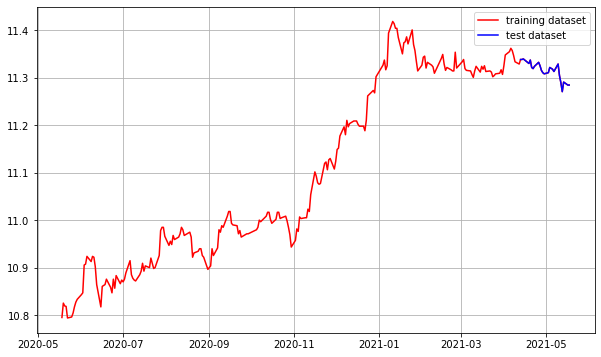

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 미래의 값을 예측해야하므로 데이터의 끝부분을 잘라 test data로 사용합니다.

## STEP 5. 적정 ARIMA 모수 찾기

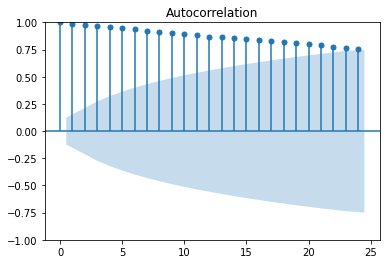

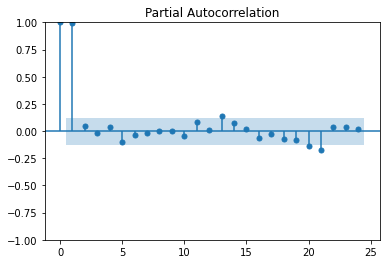

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* p가 3 이상인 구간부터 PACF가 0에 가까워졌으므로 p=2에 적합해보입니다.
* 보통 p+q < 2, pq == 0인 모수를 사용한다고 하니 q=0으로 사용합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


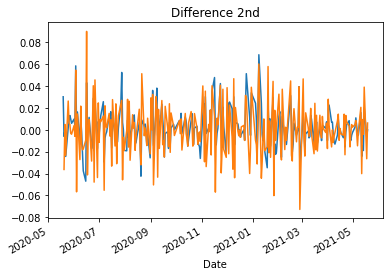

In [11]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* 1차 차분시 안정화 상태가 좋아졌지만 2차 차분시 안정화 상태가 악화되었습니다.

## STEP 6. ARIMA 모델 훈련과 테스트

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Tue, 15 Feb 2022   AIC                          -1156.722
Time:                        06:51:44   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

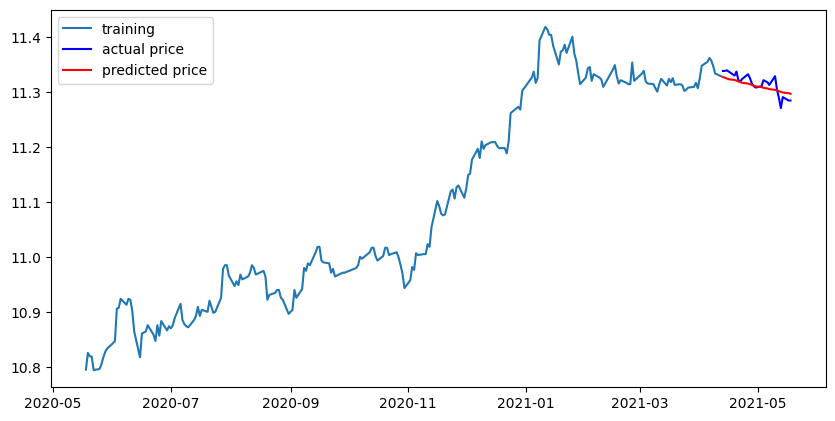

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [14]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## STEP 7. 다른 주식 종목 예측해보기

### 함수 정의
* 여러 데이터셋을 테스트하기 위해 중복된 동작을 함수로 정의합니다.

In [18]:
#결측치 제거 후 로그변환
def pre(ts):
    ts = ts.interpolate(method='time')
    ts[ts.isna()]
    ts_log = np.log(ts)
    return ts_log

# 시계열 분해
def time_series_decomposition(ts_log,window = 12):
    plot_rolling_statistics(ts_log, window=window)

    #정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

    #시계열 분해 (Time Series Decomposition)

    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return decomposition,trend,seasonal,residual

def show_a(residual):
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

def load_data(ts_log,ratio = 0.9):
    train_data, test_data = ts_log[:int(len(ts_log)*ratio)], ts_log[int(len(ts_log)*ratio):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data,test_data

# p,q 를 얻기 위한 그래프
def show_acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

#d를 얻기 위한 차분안정성 확인
def show_diff(ts_log):
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)

#모델 생성 및 훈련
def model_built(train_data,p,q,d):
    model = ARIMA(train_data, order=(p, q, d))  
    fitted_m = model.fit()
    return fitted_m

#예측
def forecast(model,test_data,alpha=0.05):
    # Forecast : 결과가 fc에 담깁니다. 
    fc = model.forecast(len(test_data), alpha=alpha)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    return fc

def result_err(test_data,fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

### 1. APPLE 주가 예측

In [20]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
Name: Close, dtype: float64

In [22]:
ts_log = pre(ts)
ts_log

Date
2021-02-16    4.891777
2021-02-17    4.873975
2021-02-18    4.865301
2021-02-19    4.866534
2021-02-22    4.836282
                ...   
2022-02-08    5.163814
2022-02-09    5.172074
2022-02-10    5.148192
2022-02-11    5.127766
2022-02-14    5.129188
Name: Close, Length: 253, dtype: float64

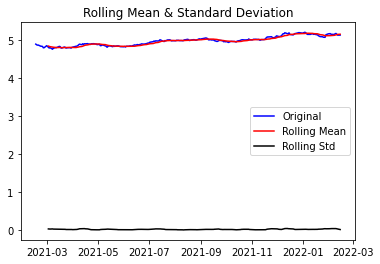

Results of Dickey-Fuller Test:
Test Statistic                  -0.745642
p-value                          0.834570
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


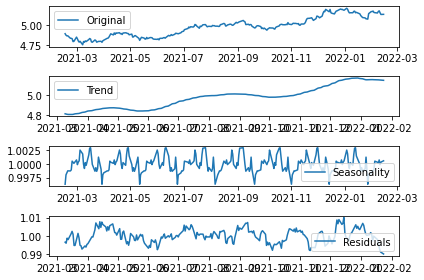

In [24]:
decomposition,trend,seasonal,residual = time_series_decomposition(ts_log,window=12)

In [26]:
#안정성을 확인합니다.
show_a(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.451186
p-value                          0.000241
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


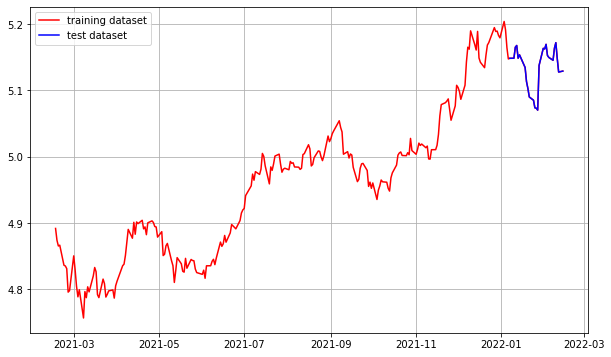

In [28]:
# 데이터 분리
train_data,test_data = load_data(ts_log)

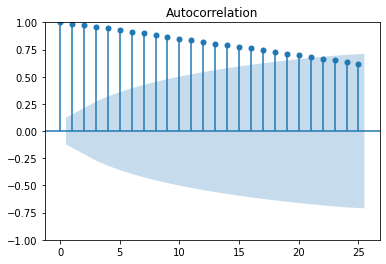

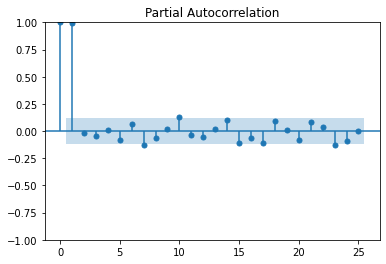

In [29]:
show_acf_pacf(ts_log)

* p=2,q=0으로 설정합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.607467e+01
p-value                        5.459468e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.589324e+00
p-value                        2.556258e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


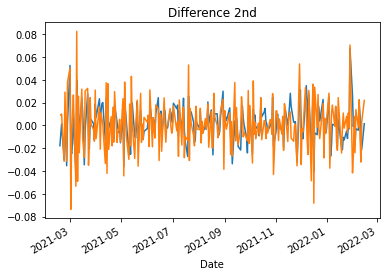

In [30]:
show_diff(ts_log)

* d = 1로 설정합니다.

In [31]:
model1 = model_built(train_data,2,0,1)

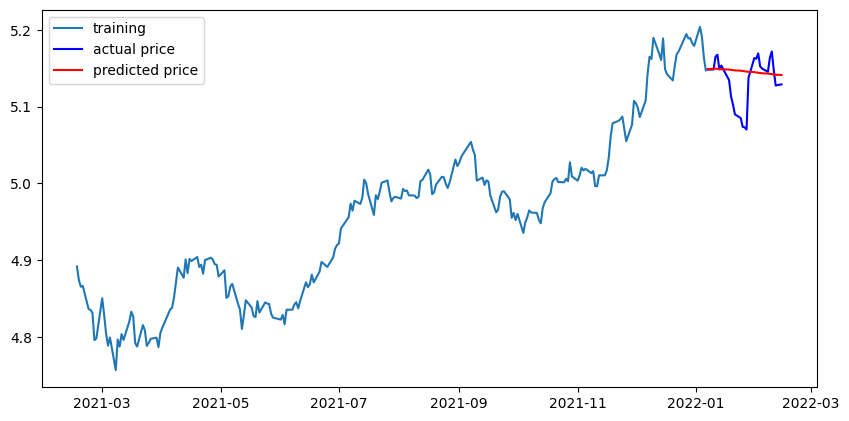

In [32]:
fc = forecast(model1,test_data)

In [33]:
result_err(test_data,fc)

MSE:  32.9271158101129
MAE:  4.177062025573407
RMSE:  5.73821538547595
MAPE: 2.52%


#### APPLE 주가 예측 모델의 MAPE는 2.52%입니다.

### 2. Microsoft 주가 예측

In [34]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-16    243.699997
2021-02-17    244.199997
2021-02-18    243.789993
2021-02-19    240.970001
2021-02-22    234.509995
Name: Close, dtype: float64

In [35]:
ts_log = pre(ts)
ts_log

Date
2021-02-16    5.495938
2021-02-17    5.497988
2021-02-18    5.496307
2021-02-19    5.484672
2021-02-22    5.457498
                ...   
2022-02-08    5.718868
2022-02-09    5.740468
2022-02-10    5.711685
2022-02-11    5.687111
2022-02-14    5.686975
Name: Close, Length: 253, dtype: float64

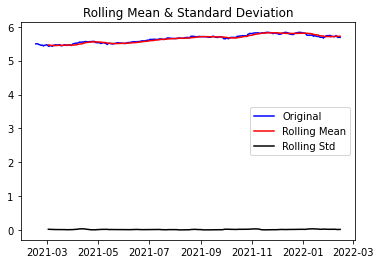

Results of Dickey-Fuller Test:
Test Statistic                  -1.319444
p-value                          0.620230
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


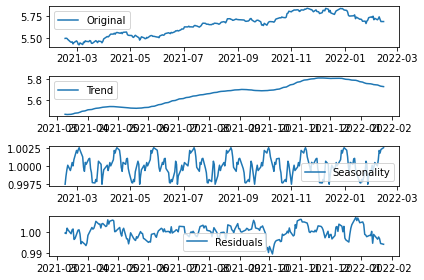

In [36]:
decomposition,trend,seasonal,residual = time_series_decomposition(ts_log,window=12)

In [37]:
show_a(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.858869
p-value                          0.000042
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


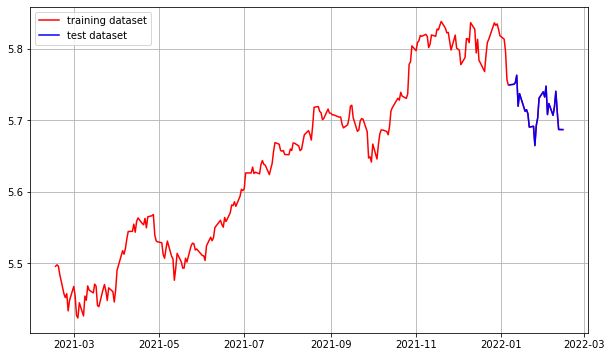

In [38]:
train_data,test_data = load_data(ts_log)

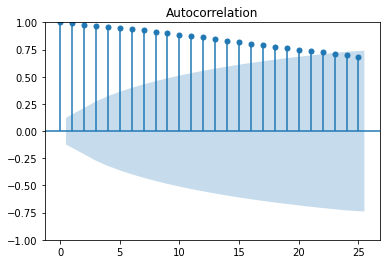

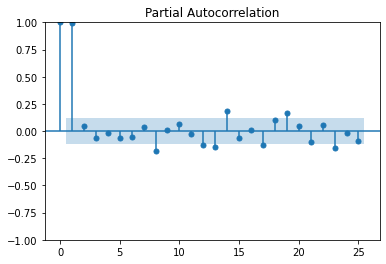

In [39]:
show_acf_pacf(ts_log)

* 역시, p = 2, q= 0으로 설정합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.657147e+01
p-value                        1.868618e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.180131e+00
p-value                        2.663192e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


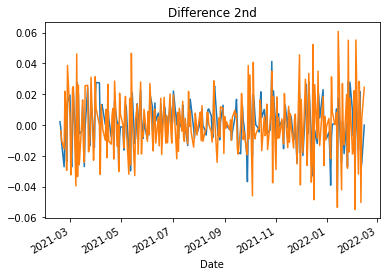

In [40]:
show_diff(ts_log)

* 2차 차분때 안정성이 좋으므로 d = 2로 설정합니다.

In [41]:
model2 = model_built(train_data,2,0,2)

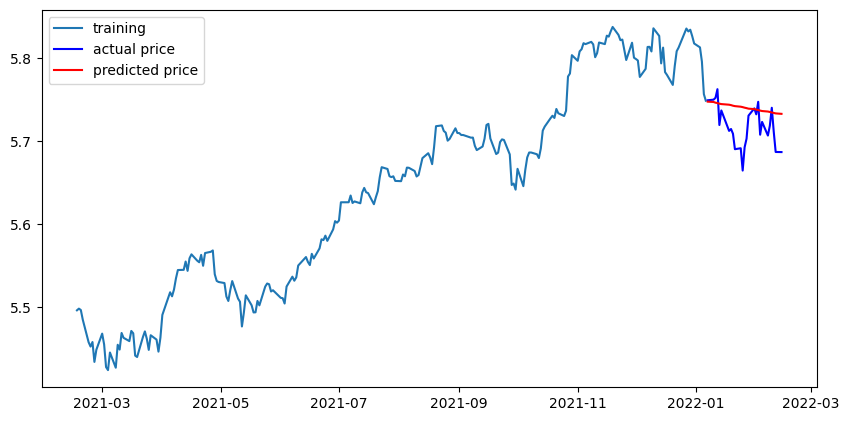

In [43]:
fc = forecast(model2,test_data)

In [44]:
result_err(test_data,fc)

MSE:  91.95449339728886
MAE:  7.650176539359653
RMSE:  9.58929055755893
MAPE: 2.56%


#### Microsoft 주가 예측 모델의 MAPE는 2.56%입니다.

### 3. TESLA 주가 예측

In [46]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-16    796.219971
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
Name: Close, dtype: float64

In [47]:
ts_log = pre(ts)
ts_log

Date
2021-02-16    6.679875
2021-02-17    6.682297
2021-02-18    6.668711
2021-02-19    6.660959
2021-02-22    6.571583
                ...   
2022-02-08    6.826545
2022-02-09    6.837333
2022-02-10    6.807438
2022-02-11    6.756932
2022-02-14    6.775092
Name: Close, Length: 253, dtype: float64

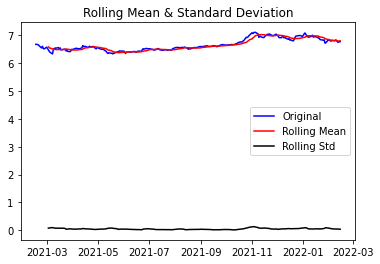

Results of Dickey-Fuller Test:
Test Statistic                  -1.309615
p-value                          0.624762
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


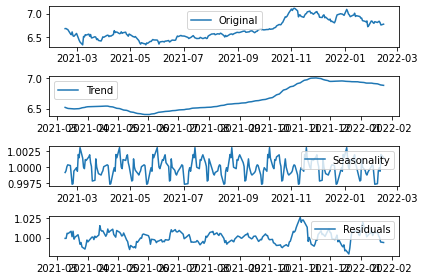

In [48]:
decomposition,trend,seasonal,residual = time_series_decomposition(ts_log,window=12)

In [49]:
show_a(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.549136e+00
p-value                        8.942189e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


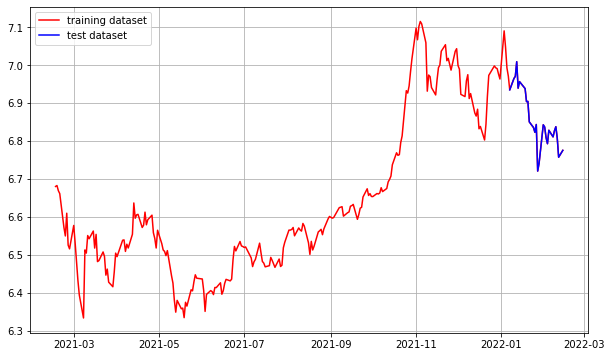

In [50]:
train_data,test_data = load_data(ts_log)

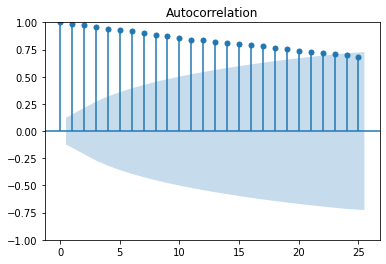

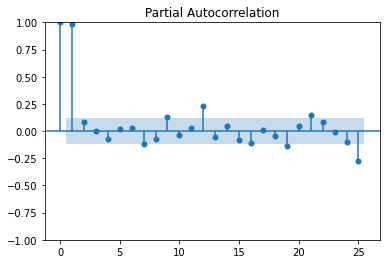

In [51]:
show_acf_pacf(ts_log)

* 역시 p = 2, q = 0으로 설정합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.684562e+01
p-value                        1.129104e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.144941e+00
p-value                        3.251080e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


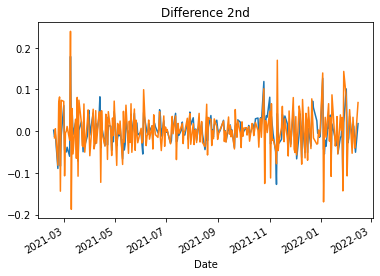

In [52]:
show_diff(ts_log)

* 1차 차분때 안정성이 높으므로 d = 1로 설정합니다.

In [81]:
model3 = model_built(train_data,2,0,2)

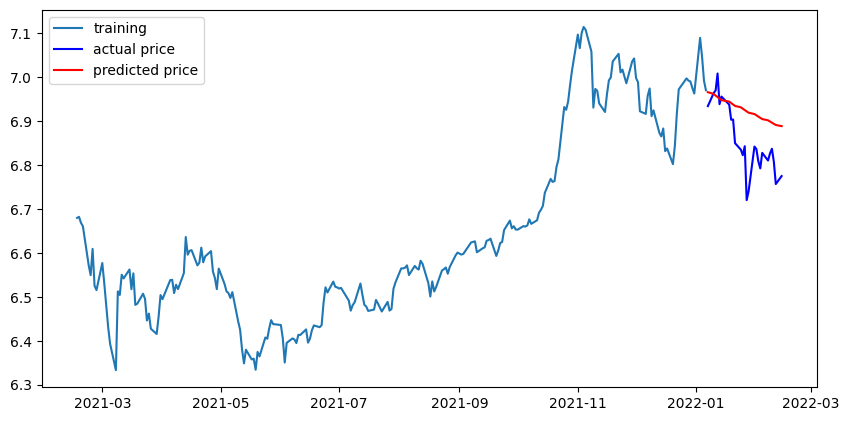

In [82]:
fc = forecast(model3,test_data)

In [83]:
result_err(test_data,fc)

MSE:  7250.054049004004
MAE:  71.93682151635268
RMSE:  85.14724921572044
MAPE: 7.92%


#### TESLA 주가 예측 모델의 MAPE는 7.92%입니다.
* 안정성이 높았던 d = 1보다 d = 2가 더 좋은 성능을 보였습니다.
* 1 기준 8.2% / 2 기준 7.92%

# 회고합시다.
* 뭔가 묘하게 예측은 잘되는 느낌입니다. 하락세를 따라가긴 하지만 따라가기만 하는 느낌?
* 주식시장은 외부 요인에 크게 영향을 받으므로 지금처럼 시계열 데이터로만 예측하는것은 조금 위험하다고 생각됩니다.
* ARIMA모델의 모수 중, d는 구한 값 이외에 다른값을 입력해 성능이 향상되는 경우가 있었지만 p와q는 성능이 크게 하락했습니다.